# Video Classification (Humpback Whales) - Keras CNN + RNN 

Source: https://keras.io/examples/vision/video_classification/


Description: Following the tutorial above to try and configure cnn + rnn combined architecture to classify youtube videos as containing a humpback whale encounter (True / relevant) or not (False / irrelevant)

Modifications (how v2 differs from v1):
- Input video size = 31 frames (since median number of frames per video = 31)
- Instead of padding videos with empty frames, pad with last available frame
- Implement 5-fold cross validation


# Setup

In [2]:
# !pip install -q git+https://github.com/tensorflow/docs

In [6]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import glob
import cv2
import os

from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns

# Get Train/Test (80/20) Datasets For Cross Validation CNN/RNN V2 Model

### Build Datasets (already done - see data_v2 folder)

In [51]:
# ## split data into train and test (no validation yet - this will come out of our train eventually)

# from sklearn.model_selection import train_test_split

# data = pd.read_csv('humpback_whale_videos_with_intervals.csv')
# data.drop(columns=['Unnamed: 0'], inplace = True)  
# df = data.copy(deep=True)

# # we want to split the data in 80:20 for train:test dataset
# train_size = 0.8

# X = df.drop(columns = ['relevant']).copy()
# y = df['relevant']

# # In the first step we will split the data in training and remaining dataset
# # note that we define the stratify parameter so we have an equal number of videos in our dataset
# # representing relevant and nonrelevant classes
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 16, stratify = y)

# #print information out
# print(X_train.shape), print(y_train.shape)
# print(X_test.shape), print(y_test.shape)

# #save X_train, y_train, X_valid, y_valid, X_test, y_test to csvs

# X_train.to_csv('data_v2/X_train.csv')
# y_train.to_csv('data_v2/y_train.csv')

# X_test.to_csv('data_v2/X_test.csv')
# y_test.to_csv('data_v2/y_test.csv')

# print('Done saving train/test datasets to csvs')

(325, 10)
(325,)
(82, 10)
(82,)
Done saving train/test datasets to csvs


### Load In Presaved Data

In [348]:
## entire unsplit dataset
# X       = pd.read_csv('humpback_whale_videos_with_intervals.csv') 
# y       = X['relevant'].to_frame()
# X       = X.drop(columns=['relevant', 'Unnamed: 0'])

## train dataset
# X_train = pd.read_csv('data_v2/X_train.csv')
# y_train = pd.read_csv('data_v2/y_train.csv')

## test dataset
# X_test = pd.read_csv('data_v2/X_test.csv')
# y_test = pd.read_csv('data_v2/y_test.csv')

# for df in [X_train, y_train, X_test, y_test]:
#     df.set_index('Unnamed: 0', inplace=True)
#     df.index.name = 'index'

# print(f"Total videos for training: {len(X_train)}")
# print(f"Total videos for testing: {len(X_test)}")

# X_train.head()

# Determine MAX_SEQ_LENGTH
Get Total Number of Frames Per Video (across all clips) + Plot (only look at training data to make decision!!)


In [4]:
## Return the number of frames per video
def get_frame_count(video_path):
    cap = cv2.VideoCapture(video_path)
    return cap.get(cv2.CAP_PROP_FRAME_COUNT)

def get_frame_counts_per_video(df):

    clip_folder = 'video_clips/'
    frame_counts_per_video = []

    for index, row in df.iterrows():

        video_name = row['renamed_title']
        
        #format video name to search for clips
        video_name = video_name.split('.mp4')[0]

        #get list of all clips belonging to the video
        video_clips = sorted([clip for clip in glob.glob(clip_folder + video_name + '*.mp4')])

        #get frame count for each video clip, add them up, and thats the total number of frames we have for the
        #content we are extracting from the video
        total_frame_count = 0
        for clip in video_clips:
            total_frame_count += get_frame_count(clip)
        frame_counts_per_video.append(total_frame_count)
    
    return frame_counts_per_video

In [8]:
#only get total frames of content available for TRAINING videos
relevant_video_frame_counts   = get_frame_counts_per_video(X_train[y_train.relevant == True])
irrelevant_video_frame_counts = get_frame_counts_per_video(X_train[y_train.relevant == False])

print(f"relevant_video_frame_counts shape: {len(relevant_video_frame_counts)}")
print(f"irrelevant_video_frame_counts shape: {len(irrelevant_video_frame_counts)}")

relevant_video_frame_counts shape: 162
irrelevant_video_frame_counts shape: 163


                               Total Frames Per Relevant Video Stats (Adjusted)                               
------------------------------------------------------------------------------------------
|       Min       |      Mean       |     Median      |       Max      |      Mode      |
------------------------------------------------------------------------------------------
          74.00          546.61          480.50          1358.00          451.00
------------------------------------------------------------------------------------------


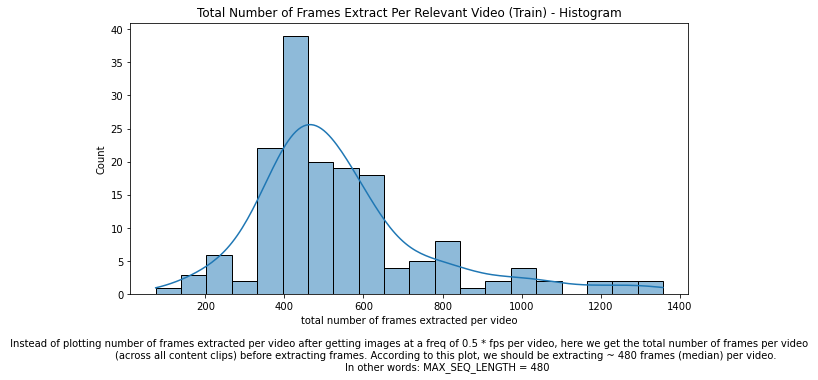

In [10]:
from statistics import mode

print(' '*30, 'Total Frames Per Relevant Video Stats (Adjusted)', ' ' * 30)
print('-'*90)
print('| {:^15} | {:^15} | {:^15} | {:^15}| {:^15}|'.format('Min','Mean','Median',' Max', 'Mode'))
print('-'*90)

print('{:>15.2f} {:>15.2f} {:>15.2f}  {:>15.2f} {:>15.2f}'.format(
                                                        np.array(relevant_video_frame_counts).min(),
                                                        np.array(relevant_video_frame_counts).mean(),
                                                        np.median(np.array(relevant_video_frame_counts)),
                                                        np.array(relevant_video_frame_counts).max(),
                                                        mode(np.array(relevant_video_frame_counts))
                                                        ))
print('-'*90)

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(np.array(relevant_video_frame_counts, dtype='float'), kde=True, ax = ax);

description = '''\n\n Instead of plotting number of frames extracted per video after getting images at a freq of 0.5 * fps per video, here we get the total number of frames per video 
                        (across all content clips) before extracting frames. According to this plot, we should be extracting ~ 480 frames (median) per video. 
                        In other words: MAX_SEQ_LENGTH = 480'''


ax.set(title= 'Total Number of Frames Extract Per Relevant Video (Train) - Histogram', xlabel = 'total number of frames extracted per video' + description );




                               Total Frames Per Irrelevant Video Stats (Adjusted)                               
------------------------------------------------------------------------------------------
|       Min       |      Mean       |     Median      |       Max      |      Mode      |
------------------------------------------------------------------------------------------
          95.00          512.93          481.00          1134.00          481.00
------------------------------------------------------------------------------------------


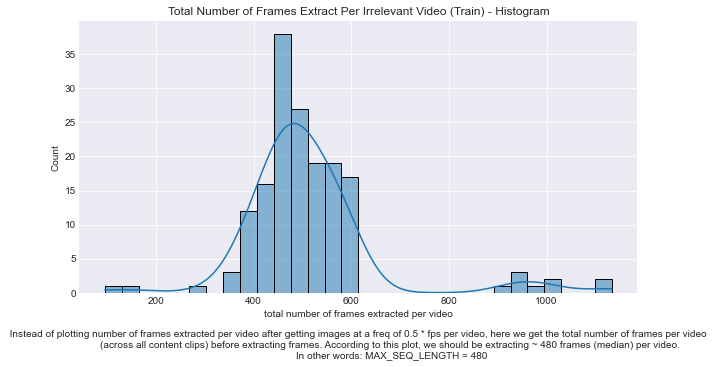

In [275]:
from statistics import mode

print(' '*30, 'Total Frames Per Irrelevant Video Stats (Adjusted)', ' ' * 30)
print('-'*90)
print('| {:^15} | {:^15} | {:^15} | {:^15}| {:^15}|'.format('Min','Mean','Median',' Max', 'Mode'))
print('-'*90)

print('{:>15.2f} {:>15.2f} {:>15.2f}  {:>15.2f} {:>15.2f}'.format(
                                                        np.array(irrelevant_video_frame_counts).min(),
                                                        np.array(irrelevant_video_frame_counts).mean(),
                                                        np.median(np.array(irrelevant_video_frame_counts)),
                                                        np.array(irrelevant_video_frame_counts).max(),
                                                        mode(np.array(irrelevant_video_frame_counts))
                                                        ))
print('-'*90)

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(np.array(irrelevant_video_frame_counts, dtype='float'), kde=True, ax = ax);

description = '''\n\n Instead of plotting number of frames extracted per video after getting images at a freq of 0.5 * fps per video, here we get the total number of frames per video 
                        (across all content clips) before extracting frames. According to this plot, we should be extracting ~ 480 frames (median) per video. 
                        In other words: MAX_SEQ_LENGTH = 480'''


ax.set(title= 'Total Number of Frames Extract Per Irrelevant Video (Train) - Histogram', xlabel = 'total number of frames extracted per video' + description );




# Define Hyperparameters

In [142]:
#need to find out what each hyperparameter is for
# [TO DO]
ROOT_DIR = os.path.dirname(os.path.abspath('video_classification_cnn_rnn_v2.ipynb'))

IMG_SIZE = 224
BATCH_SIZE = 64 
EPOCHS = None #we will tune for this using cross validation

MAX_SEQ_LENGTH = 31 #480 #31 #max frames per video (even if multiple clips)
NUM_FEATURES = 2048 #the number of features we extract from frames using InceptionV3 (kepts same as tutorial)

print(f"MAX_SEQ_LENGTH: {MAX_SEQ_LENGTH}")

MAX_SEQ_LENGTH: 31


# Data Preparation

## Checking how many frames have empty masks in our saved train/test arrays

In [276]:
train_frame_features.shape
train_frame_masks.shape

(325, 31)

Total Number of Train videos with empty frames: 88


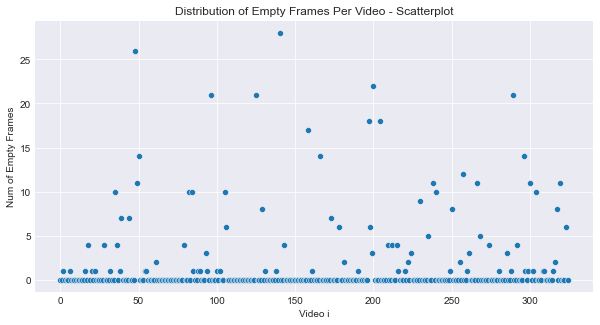

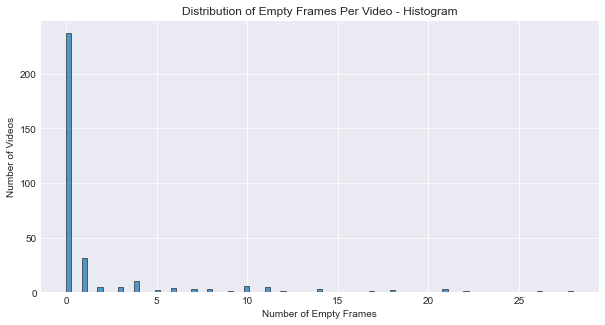

In [290]:
video_empty_frame_counts = []
for i in range(0, 325):
    num_empty = len(train_frame_masks[i][train_frame_masks[i] == False])
    video_empty_frame_counts.append(num_empty)

print(f'Total Number of Train videos with empty frames: {sum(x > 0 for x in video_empty_frame_counts)}')

#Distribution of Empty frames Per Video - Scatterplot
fig, ax = plt.subplots(figsize=(10,5));
ax = sns.scatterplot(data = video_empty_frame_counts);
ax.set(title = 'Distribution of Empty Frames Per Video - Scatterplot', xlabel = 'Video i', ylabel = 'Num of Empty Frames');

#Distribution of Empty frames Per Video - Histogram
fig, ax = plt.subplots(figsize=(10,5));
ax = sns.histplot(data = video_empty_frame_counts);
ax.set(title = 'Distribution of Empty Frames Per Video - Histogram', xlabel = 'Number of Empty Frames', ylabel = 'Number of Videos');

Observations: 
- Most videos have 0 empty frames, meaning most of our videos `don't` have empty frames, but there are still a couple train videos (88, to be exact) with empty frames. 
- The number of empty frames spans from 1 to 28 (max numbr of empty frames in train set). For our train set, we would have at most replicate a frame (ex. the last frame) 28 times

Since the max number of frames that we would need to replicate is 28, our padding strategy will start out as just replicating the last frame in order to reach our MAX_FRAMES count. The reasoning behind this is that since we would need to replicate at most 28 frames for any particular video, this means that the lowest number of actual frames we have to represent a video is 3, so the last frame is most likely similar to the other 2 (short clip), reducing our potential bias of video segment overrepresentation. 

### Padding (Attempt #1 - Pad with Last Frame of Videos)

Padding:
1. Check if the Video Needs Padding
2. If the video needs padding, replicate the last frame until MAX_FRAMES is reached

In [412]:
## Actually, we should probably get all the features, frames, and labels for each video across our ENTIRE dataset (no train/test splits)
## then do the replication on this data so we have it handy for our new cross validation application

# all_frame_features_filled = all_frame_features.copy()
# all_frame_masks_filled    = all_frame_masks.copy()
# all_labels_filled         = all_labels.copy()

# print(f"ALL Frame features: {all_frame_features_filled.shape}")
# print(f"ALL Frame masks:    {all_frame_masks_filled.shape}")
# print(f"ALL Frame labels:   {all_labels_filled.shape}")

In [400]:
## Replicate the last frame for all videos with empty frames in our unsplit dataset

for video_i in range(0, len(all_frame_masks_filled)):

    ## get empty frame indices + actual frame indices
    empty_frame_indices = [i for i,v in enumerate(all_frame_masks_filled[video_i]) if v == False]

    ## check if we have empty frames + proceed to fill in if we do
    if len(empty_frame_indices) > 0:

        ## this is the index of the frame we want to replicate for len(empty_frame_indices) times
        last_index_with_non_empty_frame = empty_frame_indices[0] - 1 

        ## get the features of the last non empty frame (this is what we will replicate)
        last_non_empty_frame = all_frame_features_filled[video_i][last_index_with_non_empty_frame]

        #fill in the empty_frame_indices in all_frame_features_filled with the last_non_empty_frame
        for empty_index in empty_frame_indices:
            all_frame_features_filled[video_i][empty_index] = last_non_empty_frame
            all_frame_masks_filled[video_i][empty_index]    = True


print('done filling frames for unsplit dataset...')


done filling frames for unsplit dataset...


Total Number of videos with empty frames: 0


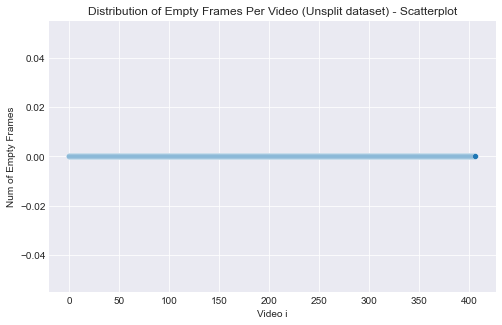

In [410]:
## plot number of empty frames to double check (all empty frame counts are 0 - we are good to go!)
video_empty_frame_counts = []
for i in range(0, 407):
    num_empty = len(all_frame_masks_filled[i][all_frame_masks_filled[i] == False])
    video_empty_frame_counts.append(num_empty)

print(f'Total Number of videos with empty frames: {sum(x > 0 for x in video_empty_frame_counts)}')

#Distribution of Empty frames Per Video - Scatterplot
fig, ax = plt.subplots(figsize=(8,5));
ax = sns.scatterplot(data = video_empty_frame_counts);
ax.set(title = 'Distribution of Empty Frames Per Video (Unsplit dataset) - Scatterplot', xlabel = 'Video i', ylabel = 'Num of Empty Frames');


In [408]:
## save the frames, masks, and a copy of their labels now that they no longer contain empty frames

# np.savez_compressed('data_v2/all_frame_features_filled.npz', all_frame_features_filled)
# np.savez_compressed('data_v2/all_frame_masks_filled.npz', all_frame_masks_filled)
# np.savez_compressed('data_v2/all_labels_filled.npz', all_labels_filled)

# print('done saving all FILLED features, masks, and labels ...')

done saving all FILLED features, masks, and labels ...


In [409]:
## to reload our filled frame features, masks, and labels for unsplit dataset
all_frame_features_filled = np.load('data_v2/all_frame_features_filled.npz')['arr_0']
all_frame_masks_filled   = np.load('data_v2/all_frame_masks_filled.npz')['arr_0']
all_labels_filled       = np.load('data_v2/all_labels_filled.npz')['arr_0']

print(f"ALL Frame features: {all_frame_features_filled.shape}")
print(f"ALL Frame masks:    {all_frame_masks_filled.shape}")
print(f"ALL Frame labels:   {all_labels_filled.shape}")

ALL Frame features: (407, 31, 2048)
ALL Frame masks:    (407, 31)
ALL Frame labels:   (407, 1)


### Load Video (Original)

In [85]:
## Get frames from a video in array format
def load_video(path, max_frames, resize=(IMG_SIZE, IMG_SIZE)):
    ''' returns array representation of image frames from video passed in'''
    
    delay = 0.5
    count = 0
    num_frames = 0

    cap = cv2.VideoCapture(path)
    frames = []
    
    # print(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    try:
        while True and num_frames < max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]  #opencv fives BGR [0,1,2] channel order; this line of code reorders our color channels to RGB [2,1,0]
            frames.append(frame)

            #to skip over some redundant frames and get more diverse set of frames over span of our video
            #while still getting a fixed, uniform number of max_frames for each video
            
            count += delay * fps
            cap.set(1, count)

            num_frames += 1

    finally:
        cap.release()

    return np.array(frames)


## use a pre-trained network to extract meaningful features from the extracted frames
## Here, we use InceptionV3 (same as tutorial), which is pre-trained on the ImageNet-1k dataset
def build_feature_extractor():
    '''Extracts meaningful features from frames using InceptionV3, which is pre-trained on ImageNet-1k dataset'''

    #instantiate InceptionV3 as feature extractor (don't include top layer bc we're not using this for classification - just feature extraction)
    feature_extractor = keras.applications.InceptionV3(
                                                        weights      = 'imagenet',
                                                        include_top  = False,
                                                        pooling      = 'avg',
                                                        input_shape  = (IMG_SIZE, IMG_SIZE, 3)
                                                    )


    #required preprocessing for inceptionV3 - scales input pixels between -1 and 1
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")



### Testing out load_video()

In [77]:
MAX_SEQ_LENGTH

31

In [78]:
## trying out load_video on an example_vid (this function gets 31 (max_frames) frames per video)
## NOTE: when dealing with multiple clips from one video, will have to set max_frames = 31/num_clips_from_video

# example_vid = 'video_clips/video_0119_clip_0.mp4'
# example_vid = 'video_clips/video_0000_clip_1.mp4'
# example_vid = 'video_clips/video_0041_clip_0.mp4'
example_vid = 'video_clips/video_0001_clip_0.mp4'

frames = load_video(example_vid, max_frames=MAX_SEQ_LENGTH)

print(frames.shape) 

(20, 224, 224, 3)


### Feature Extractor

In [70]:
## using feature_extractor to extract meaningful features from frames
feature_extractor = build_feature_extractor()
feature_extractor

### Encode labels (relevant) to numerical form before feeding them to the model

In [71]:
# encode relevant true/false labels as integers: true as 1, false as 0
def label_processor(labels_column):
    return labels_column.astype(int)

### Putting all the pieces together (load_video, preprocessing input, converting labels to int) to create our data processing utility

In [86]:
def prepare_all_videos(X, y, clip_folder, root_dir):
    num_samples = len(X)
    video_names = X["renamed_title"].values.tolist()
    labels      = y['relevant'].values 
    labels      = label_processor(labels[..., None])

    # `frame masks` and `frame_features are what we will feed to our sequence model
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is masked 
    #  with padding or not
    frame_masks    = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros( shape = (num_samples, MAX_SEQ_LENGTH, NUM_FEATURES) , dtype="float32")

    #for each video
    for index, video_name in enumerate(video_names):
        
        #Gather all its frames and add a batch dimension (frames has shape frames[None, ...])
        video_name = video_name.split('.mp4')[0]
        frames     = get_frames_for_all_clips(video_name, clip_folder, root_dir)

        #initialize placeholders to store the masks and features of the current video
        temp_frame_mask     = np.zeros(shape=(1, MAX_SEQ_LENGTH ), dtype="bool")  
        temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

        #extract features from the frames of the current video
        for i, batch in enumerate(frames):
            
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            
            temp_frame_mask[i, :length] = 1 # 1 = not masked, 0 = masked

        frame_features[index, ] = temp_frame_features.squeeze()
        frame_masks[index, ]    = temp_frame_mask.squeeze()
    
    return (frame_features, frame_masks), labels


def get_frames_for_all_clips(video, clip_folder, root_dir):

    '''
    gets the frames across all clips belonging to a video
    
    first:      find all clips belonging to video
    then:       get 40/n_clips frames from each clip (put them all in same frames array)
    finally:    add batch dimension 
    '''
    print(video)

    # find all clips from the same video
    video_clips = sorted([clip for clip in glob.glob(clip_folder + video + '*.mp4')])

    #get frames for each clip belonging to video and append to frames array
    #set max_frames_per_clip so we get MAX_SEQ_LENGTH (40) total frames for each video
    max_frames_per_clip = MAX_SEQ_LENGTH / len(video_clips)
    frames              = load_video(os.path.join(root_dir, video_clips[0]), max_frames = max_frames_per_clip)
    
    for clip_path in video_clips[1:]:
        clip_frames = load_video(os.path.join(root_dir, clip_path), max_frames = max_frames_per_clip)
        frames      = np.concatenate((frames, clip_frames))
    
    print('frames.shape: ', frames.shape)
    # add batch dimension
    return frames[None, ...]


## Preparing train and test features, masks, and labels arrays

In [89]:
# train_data, train_labels = prepare_all_videos(X_train, y_train, 'video_clips/', ROOT_DIR)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")


Frame features in train set: (325, 31, 2048)
Frame masks in train set: (325, 31)


In [94]:
# test_data, test_labels   = prepare_all_videos(X_test, y_test, 'video_clips/', ROOT_DIR)

print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")

Frame features in test set: (82, 31, 2048)
Frame masks in test set: (82, 31)


In [366]:
## getting features, masks, and labels for unsplit full data (X, y)
# all_data, all_labels    = prepare_all_videos(X, y, 'video_clips/', ROOT_DIR)

print(f"ALL Frame features: {all_data[0].shape}")
print(f"ALL Frame masks:    {all_data[1].shape}")
print(f"ALL Frame labels:   {all_labels.shape}")


ALL Frame features: (407, 31, 2048)
ALL Frame masks:    (407, 31)
ALL Frame labels:   (407, 1)


In [367]:
## saving frame features, masks, and labels ndarrays to numpy files
## source: https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/

# np.savez_compressed('data_v2/train_frame_features.npz', train_data[0])
# np.savez_compressed('data_v2/train_frame_masks.npz', train_data[1])
# np.savez_compressed('data_v2/train_labels.npz', train_labels)

# print('done saving train features, masks, and labels ...')

# np.savez_compressed('data_v2/test_frame_features.npz', test_data[0])
# np.savez_compressed('data_v2/test_frame_masks.npz', test_data[1])
# np.savez_compressed('data_v2/test_labels.npz', test_labels)

# print('done saving test features, masks, and labels ...')

np.savez_compressed('data_v2/all_frame_features.npz', all_data[0])
np.savez_compressed('data_v2/all_frame_masks.npz', all_data[1])
np.savez_compressed('data_v2/all_labels.npz', all_labels)

print('done saving all features, masks, and labels ...')

done saving all features, masks, and labels ...


In [370]:
## loading numpy arrays from npz files

# train_frame_features      = np.load('data_v2/train_frame_features.npz')['arr_0']
# train_frame_masks         = np.load('data_v2/train_frame_masks.npz')['arr_0']
# train_labels              = np.load('data_v2/train_labels.npz')['arr_0']

# test_frame_features       = np.load('data_v2/test_frame_features.npz')['arr_0']
# test_frame_masks          = np.load('data_v2/test_frame_masks.npz')['arr_0']
# test_labels               = np.load('data_v2/test_labels.npz')['arr_0']

# all_frame_features        = np.load('data_v2/all_frame_features.npz')['arr_0']
# all_frame_masks           = np.load('data_v2/all_frame_masks.npz')['arr_0']
# all_labels                = np.load('data_v2/all_labels.npz')['arr_0']

# to reload our filled frame features, masks, and labels for unsplit dataset
all_frame_features_filled = np.load('data_v2/all_frame_features_filled.npz')['arr_0']
all_frame_masks_filled    = np.load('data_v2/all_frame_masks_filled.npz')['arr_0']
all_labels_filled         = np.load('data_v2/all_labels_filled.npz')['arr_0']



In [411]:
# print('train frame features: ', train_frame_features.shape)
# print('train frame masks:    ', train_frame_masks.shape)
# print('train labels:         ', train_labels.shape)
# print('\n')

# print('test frame features: ', test_frame_features.shape)
# print('test frame masks:    ', test_frame_masks.shape)
# print('test labels:         ', test_labels.shape)
# print('\n')

# print('all frame features:  ', all_frame_features.shape)
# print('all frame masks:     ', all_frame_masks.shape)
# print('all labels:          ', all_labels.shape)

print(f"ALL Frame features filled: {all_frame_features_filled.shape}")
print(f"ALL Frame masks filled:    {all_frame_masks_filled.shape}")
print(f"ALL Frame labels filled:   {all_labels_filled.shape}")

ALL Frame features filled: (407, 31, 2048)
ALL Frame masks filled:    (407, 31)
ALL Frame labels filled:   (407, 1)


# The Sequence Model

Now, we can feed this data to a sequence model consisting of recurrent layers like GRU


### Fitting Model with Cross Validation

FIXME: should not use test set during cross validation (only train!!).
Test set should only be fed in one time, after we have decided on the best model to use

EDIT: we should actually be using cross validation to find what the best accuracy for our model is based on our entire data; this way, ever example has a chance to be part of the test set AND train set at some point

In [422]:
def get_model_name(k):
    return 'model_'+ k +'.h5'

def load_dataset(X_path, y_path):
    '''
    loads in datasets: note for data_v2 train and test, we get rid of unordered (orig) index
    and instead keep and ordered index 0...len(X) 
    
    This is what we want so that the indices in X,y match with our train/test frame feature and masks
    '''
    X = pd.read_csv(X_path)
    y = pd.read_csv(y_path)                       

    X.drop(columns=['Unnamed: 0'], inplace = True)  #since we stored our labels in y
    y.drop(columns=['Unnamed: 0'], inplace = True)
    
    print(X.shape)
    print(y.shape)

    return X, y

def load_unsplit_dataset(unsplit_csv):
    X       = pd.read_csv(unsplit_csv) 
    y       = X['relevant'].to_frame()
    X       = X.drop(columns=['relevant', 'Unnamed: 0'])

    return X, y

In [453]:
#where to store our models 
save_dir = 'saved_models_v2/'

#define the Stratified K-fold Cross Validator (use strat for equal num of class examples in folds)
fold_no   = 1
num_folds = 5
skfold    = StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)

# Store Test Acc and Loss for K-fold Cross Validation model evaluation
test_acc_per_fold       = dict()
test_loss_per_fold      = dict()
histories_per_fold      = dict()
fold_train_test_indices = dict() #{'fold_model_name': [fold_train_index_list, fold_test_index_list]}

# Load in unsplit X and y (from data_v2) + reindex so our indices match with our save features, masks, labels arrays
X, y = load_unsplit_dataset('humpback_whale_videos_with_intervals.csv')

for train_index, test_index in skfold.split(X, y):

    print('------------------------------------------------------------------------')
    # print(f"Fold {fold_no}...")
    # train_fold = y.loc[train_index]
    # test_fold  = y.loc[test_index]
    # print('num rel in train fold:   ', len(train_fold[train_fold.relevant == True]) )
    # print('num irrel in train fold: ', len(train_fold[train_fold.relevant == False]) )

    # print('num rel in test fold:     ', len(test_fold[test_fold.relevant == True]) )
    # print('num irrel in test fold:   ', len(test_fold[test_fold.relevant == False]))

    # print(train_index)
    # print(test_index)

    #get frame features and masks of train folds
    train_features_fold, train_masks_fold, train_labels_fold = all_frame_features_filled[train_index], all_frame_masks_filled[train_index], all_labels_filled[train_index]
    test_features_fold,  test_masks_fold,  test_labels_fold  = all_frame_features_filled[test_index],  all_frame_masks_filled[test_index],  all_labels_filled[test_index]


    #create + compile the model
    class_vocab          = [0, 1] 
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input           = keras.Input((MAX_SEQ_LENGTH, ), dtype="bool")

    x                    = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x                    = keras.layers.GRU(8)(x)
    x                    = keras.layers.Dropout(0.4)(x)
    x                    = keras.layers.Dense(8, activation="relu")(x)
    output               = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model            = keras.Model([frame_features_input, mask_input], output)
    rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) #ok to use sparse_categorical_crossentropy as long as we have 2 or more label classes

    #Fit data to model
    #my_callbacks only saves best weights (when best val_loss is achieved)
    fold_model_name = get_model_name(str(fold_no) + '_cv')
    filepath        = save_dir + fold_model_name
    my_callbacks    = [keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, save_best_only=True, verbose=0)]

    #Generate a print
    print(f'Training for fold {fold_no} ...')
    history = rnn_model.fit(   [train_features_fold, train_masks_fold], 
                               train_labels_fold,
                               validation_split = 0.1,
                               callbacks = my_callbacks,
                               epochs = 10,
                               verbose= 1
                            )


    # Generate metrics on validation data
    test_loss, test_accuracy = rnn_model.evaluate([test_features_fold, test_masks_fold], test_labels_fold)

    print(f'TEST Metrics for Fold {fold_no}: Accuracy = {test_accuracy}     Loss = {test_loss}')

    #store the test accuracies and loss for each fold model
    test_acc_per_fold[fold_model_name]       = test_accuracy
    test_loss_per_fold[fold_model_name]      = test_loss
    histories_per_fold[fold_model_name]      = history
    fold_train_test_indices[fold_model_name] = [train_index, test_index]
    
    print('------------------------------------------------------------------------')

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
10/10 [==============================] - 9s 303ms/step - loss: 0.6756 - accuracy: 0.6027 - val_loss: 0.6529 - val_accuracy: 0.6970
Epoch 2/10
10/10 [==============================] - 0s 40ms/step - loss: 0.6235 - accuracy: 0.6370 - val_loss: 0.5513 - val_accuracy: 0.7879
Epoch 3/10
10/10 [==============================] - 0s 39ms/step - loss: 0.5679 - accuracy: 0.7842 - val_loss: 0.4887 - val_accuracy: 0.8182
Epoch 4/10
10/10 [==============================] - 0s 40ms/step - loss: 0.4931 - accuracy: 0.8253 - val_loss: 0.4586 - val_accuracy: 0.8182
Epoch 5/10
10/10 [==============================] - 0s 40ms/step - loss: 0.4707 - accuracy: 0.8185 - val_loss: 0.4492 - val_accuracy: 0.8182
Epoch 6/10
10/10 [==============================] - 0s 42ms/step - loss: 0.4268 - accuracy: 0.8356 - val_loss: 0.4453 - val_accuracy: 0.8182
Epoch 7/10
10/10 [==============================] - 0s 4

In [454]:
test_acc_per_fold

{'model_1_cv.h5': 0.8292682766914368,
 'model_2_cv.h5': 0.8902438879013062,
 'model_3_cv.h5': 0.8024691343307495,
 'model_4_cv.h5': 0.8395061492919922,
 'model_5_cv.h5': 0.8518518805503845}

In [455]:
test_loss_per_fold

{'model_1_cv.h5': 0.432155966758728,
 'model_2_cv.h5': 0.31260186433792114,
 'model_3_cv.h5': 0.4284442961215973,
 'model_4_cv.h5': 0.3782363831996918,
 'model_5_cv.h5': 0.38905829191207886}

In [456]:
histories_per_fold

{'model_1_cv.h5': <keras.callbacks.History at 0x1dfec4b50>,
 'model_2_cv.h5': <keras.callbacks.History at 0x1e17179a0>,
 'model_3_cv.h5': <keras.callbacks.History at 0x1e12e6b20>,
 'model_4_cv.h5': <keras.callbacks.History at 0x1e3951bb0>,
 'model_5_cv.h5': <keras.callbacks.History at 0x1e519ca90>}

In [457]:
fold_train_test_indices

{'model_1_cv.h5': [array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  17,  18,  19,  20,  21,  22,  24,  26,  27,  28,  29,  30,
          31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  45,
          46,  47,  50,  51,  52,  53,  55,  56,  57,  58,  59,  60,  61,
          62,  63,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          79,  80,  81,  83,  84,  85,  86,  87,  88,  90,  91,  93,  94,
          97,  98, 100, 102, 103, 105, 107, 108, 109, 110, 111, 112, 113,
         114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 128, 129,
         130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 145,
         146, 147, 149, 151, 155, 158, 160, 162, 163, 164, 165, 167, 168,
         170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 182, 183, 184,
         185, 186, 187, 188, 191, 192, 194, 195, 196, 197, 198, 199, 201,
         202, 203, 204, 205, 206, 210, 211, 212, 213, 214, 216, 217, 218,
         219, 220, 22

In [458]:
cross_val_avg_accuracy = np.mean(list(test_acc_per_fold.values()))
cross_val_avg_loss     = np.mean(list(test_loss_per_fold.values()))

print(f"Average Accuracy with Cross Validation: {cross_val_avg_accuracy}")
print(f"Average Loss with Cross Validation:     {cross_val_avg_loss}")


Average Accuracy with Cross Validation: 0.8426678657531739
Average Loss with Cross Validation:     0.3880993604660034


## `[TO DO]` : need to figure out how to get CM + other metrics below when we don't have an `actual` model that gives us the 84% accuracy

# Inference

In [160]:
def prepare_single_video(frames):
    frame_mask     = np.zeros(shape=(1, MAX_SEQ_LENGTH, ), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i,j,:] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1 #1 = not masked, 0 = masked

    return frame_features, frame_mask

#generates prediction and accuracy scores for a single video with model passed in
def sequence_prediction(path, model, silent=False):
    class_vocab = [0, 1] #label_processor.get_vocabulary()

    # Gather all its frames and add a batch dimension (frames has shape frames[None, ...])
    path   = path.split('.mp4')[0]
    frames = get_frames_for_all_clips(path, "video_clips/", ROOT_DIR)
    
    frame_features, frame_mask = prepare_single_video(frames)
    
    probabilities = model.predict([frame_features, frame_mask])[0]

    if silent == False:
        for i in np.argsort(probabilities)[::-1]:
            print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    
    return frames, probabilities

# This utility is for visualization. Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images, video_name, saveto_path):
    
    converted_images = images.astype(np.uint8)
    imageio.mimsave(f"{saveto_path}{video_name}.gif", converted_images, fps=10)
    return embed.embed_file(f"{saveto_path}{video_name}.gif")


## Running Our Model on Our Entire Test Set + Getting DF with video_name, true label, pred labels

### Specify Model Version (For Saving Figures Purposes)

In [156]:
model_version = 'v2'

### Get Test Classifications

In [157]:
X_train, y_train = load_dataset('data_v2/X_train.csv', 'data_v2/y_train.csv')
X_test, y_test   = load_dataset('data_v2/X_test.csv', 'data_v2/y_test.csv')

(325, 10)
(325, 1)
(82, 10)
(82, 1)


In [161]:
# Order is not maintained in predictions generated by model, so to truly make sure a prediction belongs to a video, we will feed in each video in our test set individually 
# and get pred to create df containing video name, true label, and pred label

# note: when we run our model on the videos in the test set, we're feeding in its clips rather than the entire video for consistency with the test evaluation done in
# `run_experiment()`

test_classifications = pd.DataFrame({'video': list(X_test['renamed_title']),
                                     'true': list(y_test['relevant'].astype("int")),
                                     'pred': [None for i in range(0, len(X_test))]
                                    })

probs = []
for index, row in test_classifications.iterrows():
  video = row['video']

  #get + display the prediction probabilities
  frames, probabilities = sequence_prediction(path = video, model = rnn_model, silent=True)

  probs.append(probabilities)
  test_classifications.at[index, 'pred'] = np.argmax(probabilities)


#save as csv 
test_classifications.to_csv(f"model_figures/test_classifications_model_{model_version}.csv")

test_classifications.head()

video_0664
frames.shape:  (31, 224, 224, 3)
video_0722
frames.shape:  (30, 224, 224, 3)
video_0017
frames.shape:  (13, 224, 224, 3)
video_0766
frames.shape:  (31, 224, 224, 3)
video_0079
frames.shape:  (32, 224, 224, 3)
video_0725
frames.shape:  (30, 224, 224, 3)
video_0545
frames.shape:  (31, 224, 224, 3)
video_0618
frames.shape:  (31, 224, 224, 3)
video_0062
frames.shape:  (24, 224, 224, 3)
video_0637


[h264 @ 0x7fe71d26e200] mmco: unref short failure
[h264 @ 0x7fe71d26e200] mmco: unref short failure
[h264 @ 0x7fe71d26e200] mmco: unref short failure
[h264 @ 0x7fe71d26e200] mmco: unref short failure
[h264 @ 0x7fe71d26e200] mmco: unref short failure
[h264 @ 0x7fe71d26e200] mmco: unref short failure


frames.shape:  (31, 224, 224, 3)
video_0092
frames.shape:  (23, 224, 224, 3)
video_0104
frames.shape:  (21, 224, 224, 3)
video_0039
frames.shape:  (11, 224, 224, 3)
video_0743
frames.shape:  (31, 224, 224, 3)
video_0669
frames.shape:  (31, 224, 224, 3)
video_0016


[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure
[h264 @ 0x7fe6fe7e5c00] mmco: unref short failure


frames.shape:  (31, 224, 224, 3)
video_0050
frames.shape:  (20, 224, 224, 3)
video_0625
frames.shape:  (31, 224, 224, 3)
video_0074
frames.shape:  (27, 224, 224, 3)
video_0741
frames.shape:  (30, 224, 224, 3)
video_0009
frames.shape:  (31, 224, 224, 3)
video_0724
frames.shape:  (31, 224, 224, 3)
video_0061
frames.shape:  (27, 224, 224, 3)
video_0632
frames.shape:  (31, 224, 224, 3)
video_0579
frames.shape:  (31, 224, 224, 3)
video_0711
frames.shape:  (31, 224, 224, 3)
video_0667
frames.shape:  (31, 224, 224, 3)
video_0101
frames.shape:  (24, 224, 224, 3)
video_0505
frames.shape:  (31, 224, 224, 3)
video_0641
frames.shape:  (31, 224, 224, 3)
video_0603
frames.shape:  (31, 224, 224, 3)
video_0148
frames.shape:  (31, 224, 224, 3)
video_0115
frames.shape:  (31, 224, 224, 3)
video_0010
frames.shape:  (26, 224, 224, 3)
video_0015
frames.shape:  (18, 224, 224, 3)
video_0091
frames.shape:  (18, 224, 224, 3)
video_0040
frames.shape:  (31, 224, 224, 3)
video_0757
frames.shape:  (30, 224, 224, 3)

[h264 @ 0x7fe705321a00] mmco: unref short failure
[h264 @ 0x7fe705321a00] mmco: unref short failure
[h264 @ 0x7fe705321a00] mmco: unref short failure
[h264 @ 0x7fe705321a00] mmco: unref short failure


frames.shape:  (31, 224, 224, 3)
video_0068
frames.shape:  (29, 224, 224, 3)
video_0709
frames.shape:  (31, 224, 224, 3)
video_0096
frames.shape:  (32, 224, 224, 3)
video_0756
frames.shape:  (31, 224, 224, 3)
video_0555
frames.shape:  (30, 224, 224, 3)
video_0019
frames.shape:  (24, 224, 224, 3)
video_0629


[h264 @ 0x7fe71d120600] mmco: unref short failure
[h264 @ 0x7fe71d120600] mmco: unref short failure
[h264 @ 0x7fe71d120600] mmco: unref short failure
[h264 @ 0x7fe71d120600] mmco: unref short failure
[h264 @ 0x7fe71d120600] mmco: unref short failure
[h264 @ 0x7fe71d120600] mmco: unref short failure
[h264 @ 0x7fe71d120600] mmco: unref short failure
[h264 @ 0x7fe71d120600] mmco: unref short failure
[h264 @ 0x7fe71d120600] mmco: unref short failure
[h264 @ 0x7fe71d120600] mmco: unref short failure
[h264 @ 0x7fe71d120600] mmco: unref short failure


frames.shape:  (31, 224, 224, 3)
video_0034
frames.shape:  (11, 224, 224, 3)
video_0695
frames.shape:  (31, 224, 224, 3)
video_0776
frames.shape:  (31, 224, 224, 3)
video_0031
frames.shape:  (26, 224, 224, 3)
video_0046
frames.shape:  (7, 224, 224, 3)
video_0623
frames.shape:  (14, 224, 224, 3)
video_0126


[h264 @ 0x7fe77b050600] mmco: unref short failure


frames.shape:  (31, 224, 224, 3)
video_0715
frames.shape:  (31, 224, 224, 3)
video_0129
frames.shape:  (31, 224, 224, 3)
video_0762
frames.shape:  (31, 224, 224, 3)
video_0647
frames.shape:  (31, 224, 224, 3)
video_0768
frames.shape:  (31, 224, 224, 3)
video_0593
frames.shape:  (31, 224, 224, 3)
video_0814
frames.shape:  (31, 224, 224, 3)
video_0037
frames.shape:  (31, 224, 224, 3)
video_0759
frames.shape:  (31, 224, 224, 3)
video_0560
frames.shape:  (31, 224, 224, 3)


,video,true,pred
0,video_0664.mp4,1,1
1,video_0722.mp4,0,0
2,video_0017.mp4,1,0
3,video_0766.mp4,0,0
4,video_0079.mp4,1,1


In [162]:
#finding which videos were incorrectly classified (pred labeled != true label)
incorrect_classifications = test_classifications[test_classifications.true != test_classifications.pred].copy(deep=True)
incorrect_classifications


,video,true,pred
2,video_0017.mp4,1,0
7,video_0618.mp4,0,1
9,video_0637.mp4,1,0
27,video_0101.mp4,1,0
32,video_0115.mp4,0,1
38,video_0567.mp4,0,1
39,video_0513.mp4,0,1
40,video_0109.mp4,0,1
42,video_0810.mp4,0,1
48,video_0665.mp4,1,0


In [163]:
#put true and pred labels in variables for easy use later on
y_true = list(test_classifications['true'])
y_pred = list(test_classifications['pred'])

### Plotting Model Accuracy + Loss Curves

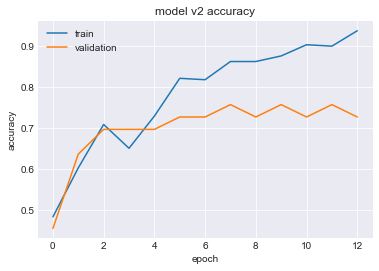

In [164]:
plt.style.use('seaborn-darkgrid')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title(f"model {model_version} accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.savefig(f"model_figures/model_{model_version}_train_accuracy.png")

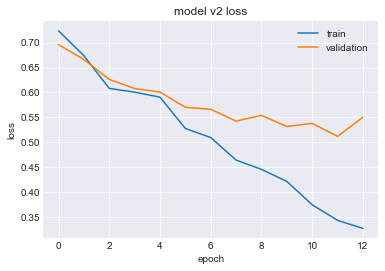

In [165]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title(f"model {model_version} loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.savefig(f"model_figures/model_{model_version}_train_loss.png")

### Accuracy on Test Set

In [166]:
#when only (occurence + random irrelevant) clips associated with test videos were fed into model (w/ constrained number of frames)
print(f"Accuracy on Test Set for model {model_version}: ",  metrics.accuracy_score(y_true, y_pred))
print(f"Error on Test Set for model {model_version}   : ", 1 - metrics.accuracy_score(y_true, y_pred))

Accuracy on Test Set for model v2:  0.8048780487804879
Error on Test Set for model v2   :  0.19512195121951215


### Confusion Matrix

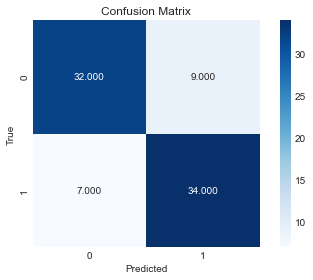

In [167]:
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()

plt.savefig(f"model_figures/model_{model_version}_confusion_matrix")

Interpretation: 
- Model v1 is pretty balanced at correctly predicting each class (slight bias towards predicting videos as relevant). Predicts that actual non-relevant videos are relevant more often than the other way around (predicting actual relevant videos to be nonrelevant)

### Precision - Recall - F1

In [171]:
precision, recall, f1, support =  metrics.precision_recall_fscore_support(y_true, y_pred)

print('----- metrics for classes [0 1] -----')
print('precision:', precision)
print('recall:   ', recall) 
print('f1 score: ', f1)
print('support:  ', support)

----- metrics for classes [0 1] -----
precision: [0.82051282 0.79069767]
recall:    [0.7804878  0.82926829]
f1 score:  [0.8        0.80952381]
support:   [41 41]


### Examining + Visualizing Which Videos Were Incorrectly Classified

In [228]:
print(f"For model_v2, there were {len(incorrect_classifications)} incorrect classifications")
incorrect_classifications

For model_v2, there were 16 incorrect classifications


,video,true,pred
2,video_0017.mp4,1,0
7,video_0618.mp4,0,1
9,video_0637.mp4,1,0
27,video_0101.mp4,1,0
32,video_0115.mp4,0,1
38,video_0567.mp4,0,1
39,video_0513.mp4,0,1
40,video_0109.mp4,0,1
42,video_0810.mp4,0,1
48,video_0665.mp4,1,0


In [179]:
#getting gifs for incorrect classificaitons
#gifs are saved in 'model_v2_misclassified_gifs/'

for index, row in incorrect_classifications.iterrows():
    test_video = row['video']
    
    #display info about video 
    print(f"Test video path: {test_video}")
    print(f"True Label: {row['true']}  Pred Label: {row['pred']}")

    #print an interpretation of classification results
    if (row['true'] == 0) and (row['pred'] == 1):
        print('Interpretation: Model predicted video to be relevant but video is actually irrelevant (no humpback whales)\n')
    elif (row['true'] == 1) and (row['pred'] == 0):
        print('Interpretation: Model predicted video to be irrelevant but video is actually relevant (does have humpback whales)\n')

    #get + display the prediction probabilities
    test_frames, class_probabilities = sequence_prediction(path = test_video, model = rnn_model, silent=True) #sequence_prediction(test_video, video_folder="video_clips", silent=True)

    # print(test_frames.shape)
    # print(test_frames[1:MAX_SEQ_LENGTH].shape)
    # print(np.squeeze(test_frames, axis=0).shape)

    # display video as gif of frames (note that we get rid of the None dimension in test_frames
    # by doing starting at index 1, since we modified the sequence_prediction function to work with our multiple clips from one video)
    test_frames_squeezed = np.squeeze(test_frames, axis=0) #to get rid of the extra None dimension and bring frames back to orig dims
    to_gif(test_frames_squeezed[:MAX_SEQ_LENGTH], video_name = test_video.split('.mp4')[0], saveto_path= 'model_v2_misclassified_gifs/')



Test video path: video_0017.mp4
True Label: 1  Pred Label: 0
Interpretation: Model predicted video to be irrelevant but video is actually relevant (does have humpback whales)

video_0017
frames.shape:  (13, 224, 224, 3)
Test video path: video_0618.mp4
True Label: 0  Pred Label: 1
Interpretation: Model predicted video to be relevant but video is actually irrelevant (no humpback whales)

video_0618
frames.shape:  (31, 224, 224, 3)
Test video path: video_0637.mp4
True Label: 1  Pred Label: 0
Interpretation: Model predicted video to be irrelevant but video is actually relevant (does have humpback whales)

video_0637


[h264 @ 0x7fe7855d6200] mmco: unref short failure
[h264 @ 0x7fe7855d6200] mmco: unref short failure
[h264 @ 0x7fe7855d6200] mmco: unref short failure
[h264 @ 0x7fe7855d6200] mmco: unref short failure
[h264 @ 0x7fe7855d6200] mmco: unref short failure
[h264 @ 0x7fe7855d6200] mmco: unref short failure


frames.shape:  (31, 224, 224, 3)
Test video path: video_0101.mp4
True Label: 1  Pred Label: 0
Interpretation: Model predicted video to be irrelevant but video is actually relevant (does have humpback whales)

video_0101
frames.shape:  (24, 224, 224, 3)
Test video path: video_0115.mp4
True Label: 0  Pred Label: 1
Interpretation: Model predicted video to be relevant but video is actually irrelevant (no humpback whales)

video_0115
frames.shape:  (31, 224, 224, 3)
Test video path: video_0567.mp4
True Label: 0  Pred Label: 1
Interpretation: Model predicted video to be relevant but video is actually irrelevant (no humpback whales)

video_0567
frames.shape:  (31, 224, 224, 3)
Test video path: video_0513.mp4
True Label: 0  Pred Label: 1
Interpretation: Model predicted video to be relevant but video is actually irrelevant (no humpback whales)

video_0513
frames.shape:  (30, 224, 224, 3)
Test video path: video_0109.mp4
True Label: 0  Pred Label: 1
Interpretation: Model predicted video to be rel

[h264 @ 0x7fe77c6e3600] mmco: unref short failure
[h264 @ 0x7fe77c6e3600] mmco: unref short failure
[h264 @ 0x7fe77c6e3600] mmco: unref short failure
[h264 @ 0x7fe77c6e3600] mmco: unref short failure


frames.shape:  (31, 224, 224, 3)
Test video path: video_0629.mp4
True Label: 1  Pred Label: 0
Interpretation: Model predicted video to be irrelevant but video is actually relevant (does have humpback whales)

video_0629


[h264 @ 0x7fe781757800] mmco: unref short failure
[h264 @ 0x7fe781757800] mmco: unref short failure
[h264 @ 0x7fe781757800] mmco: unref short failure
[h264 @ 0x7fe781757800] mmco: unref short failure
[h264 @ 0x7fe781757800] mmco: unref short failure
[h264 @ 0x7fe781757800] mmco: unref short failure
[h264 @ 0x7fe781757800] mmco: unref short failure
[h264 @ 0x7fe781757800] mmco: unref short failure
[h264 @ 0x7fe781757800] mmco: unref short failure
[h264 @ 0x7fe781757800] mmco: unref short failure
[h264 @ 0x7fe781757800] mmco: unref short failure


frames.shape:  (31, 224, 224, 3)
Test video path: video_0695.mp4
True Label: 1  Pred Label: 0
Interpretation: Model predicted video to be irrelevant but video is actually relevant (does have humpback whales)

video_0695
frames.shape:  (31, 224, 224, 3)
Test video path: video_0776.mp4
True Label: 0  Pred Label: 1
Interpretation: Model predicted video to be relevant but video is actually irrelevant (no humpback whales)

video_0776
frames.shape:  (31, 224, 224, 3)
Test video path: video_0762.mp4
True Label: 0  Pred Label: 1
Interpretation: Model predicted video to be relevant but video is actually irrelevant (no humpback whales)

video_0762
frames.shape:  (31, 224, 224, 3)


In [231]:
print(f"For model_v2 (CV + hypertuned params), there were {len(incorrect_classifications[incorrect_classifications.pred == 1])} videos misclassified as being relevant") #9
print(f"For model_v2 (CV + hypertuned params), there were {len(incorrect_classifications[incorrect_classifications.pred == 0])} videos miscalssified as being irrelevant") #7


For model_v2 (CV + hypertuned params), there were 9 videos misclassified as being relevant
For model_v2 (CV + hypertuned params), there were 7 videos miscalssified as being irrelevant


## Comparing Classifications Between Model v1 and Model v2
(note some videos found in v2 data may be missing in v1 data)

In [223]:
model_v1_predictions = pd.read_csv('model_figures/test_classifications_model_v1.csv')
model_v2_predictions = pd.read_csv('model_figures/test_classifications_model_v2.csv')

model_v1_predictions = model_v1_predictions.drop(columns=['Unnamed: 0'])
model_v2_predictions = model_v2_predictions.drop(columns=['Unnamed: 0'])

#finding which videos were incorrectly classified (pred labeled != true label)
incorrect_classifications_v1 = model_v1_predictions[model_v1_predictions.true != model_v1_predictions.pred]
incorrect_classifications_v2 = model_v2_predictions[model_v2_predictions.true != model_v2_predictions.pred]

#find the subset of videos that are in model_v1 incorrect classifications and model_v2 incorrect classifications
both_incorrect_classifications = [video for video in list(incorrect_classifications_v1.video) if video in list(incorrect_classifications_v2.video) ]

#incorrect classifications from model v2 at overlapping misclassified videos
df1 = incorrect_classifications_v2[incorrect_classifications_v2['video'].isin(both_incorrect_classifications)]

#incorrect classifications from model v1 at overlapping misclassified videos
df2 = incorrect_classifications_v1[incorrect_classifications_v1['video'].isin(both_incorrect_classifications)]

result = pd.merge(df1, df2, on='video', suffixes=['_model_v1', '_model_v2'])
result

,video,true_model_v1,pred_model_v1,true_model_v2,pred_model_v2
0,video_0618.mp4,0,1,0,1
1,video_0101.mp4,1,0,1,0
2,video_0115.mp4,0,1,0,1
3,video_0513.mp4,0,1,0,1
4,video_0810.mp4,0,1,0,1
5,video_0629.mp4,1,0,1,0
6,video_0695.mp4,1,0,1,0
7,video_0776.mp4,0,1,0,1
8,video_0762.mp4,0,1,0,1


----
### Notes + Observations on Misclassifications:

1. Model v2
- misclassified videos tend to be irrelevant videos misclassified as relevant (9) rather than relevant videos misclassified as irrelevant (7)
- model v2 also misclassifies the same videos that model v1 misclassified, plus a couple more (this may be due to the fact that our X_train here was bigger than the X_train that model V1 received since we didnt split our entire data into train/val/test). However, the models both misclassify the same videos in the same way (see result df above)
- regarding content of videos misclassified: same as content as the misclassified videos from model v1 (hard to see, underwater, other types of marine animals). 

----

### To Do / Next Steps: 
- pad videos with repeated frames instead of black frames

# Other Resources to Read:
- https://towardsdatascience.com/introduction-to-video-classification-6c6acbc57356 (for ideas on other strategies to try)
- https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5 